In [11]:
# TODO: change this code to use NonTerminal instead of price
import sys
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book')
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\MDP-DP-RL\src')

from dataclasses import dataclass
from typing import Callable, List, Sequence
from rl.markov_decision_process import NonTerminal, State, Terminal
from numpy.polynomial.laguerre import lagval
import numpy as np
import matplotlib.pyplot as plt
import copy
from utils.gen_utils import memoize


@dataclass(frozen=True)
class OptimalExerciseLS:
    
    spot_price: float
    payoff: Callable[[float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int
    spot_price_frac: float # better name than spot_price_frac
       
    # TODO why do we have a spot_price_frac?
    # TODO verify that my process behaves correctly
    # TODO check that I get the same results as Prof Rao's original code
#     @memoize
    def _get_all_paths(
        self,
        spot_price_frac: float,
        num_paths: int,
        num_dt: int
    ) -> np.ndarray:
        dt = self.expiry / num_dt
        paths = np.empty([num_paths, num_dt + 1])
        spot = self.spot_price
        for i in range(num_paths):
            start = max(0.001, np.random.normal(spot, spot * spot_price_frac))
            paths[i, 0] = start
            for t in range(num_dt):
                mean = np.log(paths[i,t]) + (self.rate - self.vol * self.vol / 2) * dt
                std  = self.vol * np.sqrt(dt) 
                paths[i, t + 1] = np.exp(np.random.normal(mean, std))
        return paths


    # TODO: verify that the discount I use is OK
    # TODO: may operations could be vectorized
    def get_price(
        self,
        num_dt: int,
        num_paths: int,
        feature_funcs: Sequence[Callable[[NonTerminal[float]], float]]
    ) -> float:
        paths = self._get_all_paths(0.0, num_paths, num_dt)

        cashflow = np.array([self.payoff(paths[i,-1])
                             for i in range(num_paths)])
        dt = self.expiry / num_dt

        ex_boundary_price_range = (0,80)  # TODO: this approach won't work for call options (no need for boundary in call 
                                           #       options) Also, this is hardcoded stike price. I did change the stprcs uses
                                            # below with path_values
        stprcs = np.arange(*ex_boundary_price_range)
        final = [(p, self.payoff(p)) for p in stprcs]
        ex_boundary = [max(p for p, e in final if e > 0)]

        for step in range(num_dt - 1, 0, -1):
            """
            For each time slice t
            Step 1: collect X as features of (t, [S_0,.., S_t]) for those paths
            for which payoff(t, [S_0, ...., S_t]) > 0, and corresponding Y as
            the time-t discounted future actual cash flow on those paths.
            Step 2: Do the (X,Y) regression. Denote Y^ as regression-prediction.
            Compare Y^ versus payoff(t, [S_0, ..., S_t]). If payoff is higher,
            set cashflow at time t on that path to be the payoff, else set 
            cashflow at time t on that path to be the time-t discounted future
            actual cash flow on that path.
            """
            t = step * dt
            disc = np.exp(-self.rate * dt)
            cashflow = cashflow * disc
            payoff = np.array([self.payoff(paths[i,step]) for i in range(num_paths)])
            indices = [i for i in range(num_paths) if payoff[i] > 0]
            if len(indices) > 0:
                path_values = sorted([paths[i, step] for i in indices])
                x_vals = np.array([[f(NonTerminal(paths[i, step])) for f in feature_funcs] for i in indices])
                y_vals = np.array([cashflow[i] for i in indices])
                weights = np.linalg.lstsq(x_vals, y_vals, rcond=None)[0]
                estimate = x_vals.dot(weights)
#                 plt.scatter([paths[i, step] for i in indices], y_vals, c='r')
#                 plt.scatter([paths[i, step] for i in indices], estimate, c='b')
#                 plt.plot([paths[i, step] for i in indices], [self.payoff(paths[i, step]) for i in indices], c='g')
#                 plt.show()

                for i, ind in enumerate(indices):
                    if payoff[ind] > estimate[i]:
                        cashflow[ind] = payoff[ind]

                cp = [weights.dot([f(NonTerminal(s)) for f in feature_funcs]) for s in path_values]
                ep = [self.payoff(s) for s in path_values]
                ll = [p for p, c, e in zip(path_values, cp, ep) if e > c]
                if len(ll) == 0:
                    num = 0. # TODO: check if the following lines that I added (instead of simply setting to 0, set to previous value)
#                     if len(ex_boundary) != 0:
#                         num = ex_boundary[-1]
#                     else:
#                         num = 0
                else:
                    num = max(ll)
                ex_boundary.append(num)
                # plot the continuation and exercise value functions at step step
                if step % 10 == 0:
                    plt.title("LS Time = %.3f" % t)
                    plt.scatter([paths[i, step] for i in indices], y_vals,s=5)
                    plt.plot(path_values, cp, 'r', path_values, ep, 'b')
                    plt.show()

        # plot the exercise boundary
        plt.plot([t * dt for t in range(1, num_dt + 1)], ex_boundary[::-1])
        plt.title("LS Boundary")
        plt.show
#         plt.savefig(str(Path.home()) + "/Downloads/LSBoundary.png")

        return max(
            self.payoff(self.spot_price),
            np.average(cashflow * np.exp(-self.rate * dt))
        ), ex_boundary[::-1] #TODO: I think I have reversed it
                       #TODO: only have the exercise boundary if it is a put option




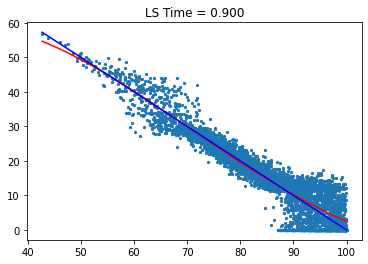

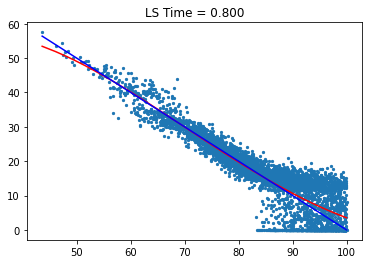

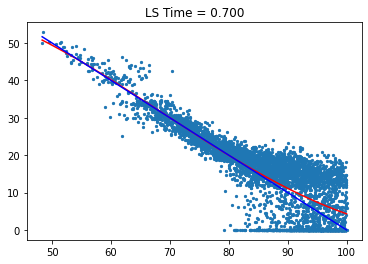

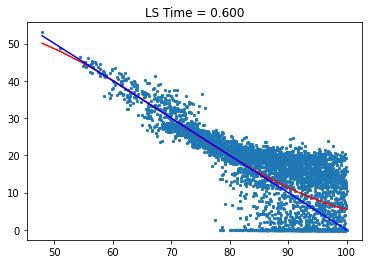

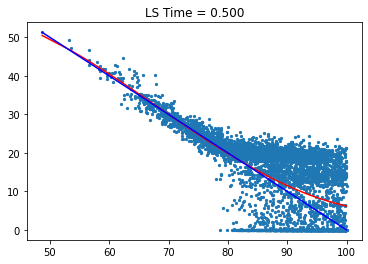

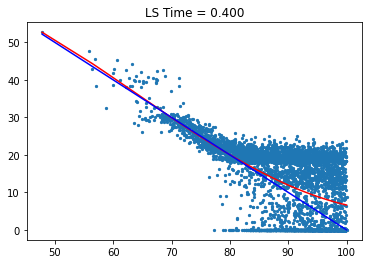

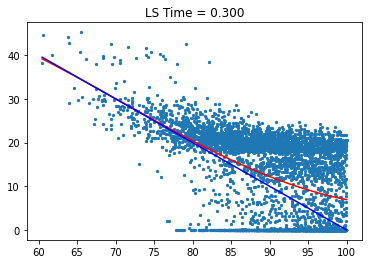

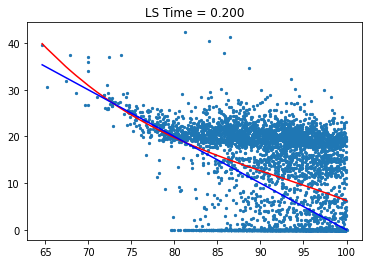

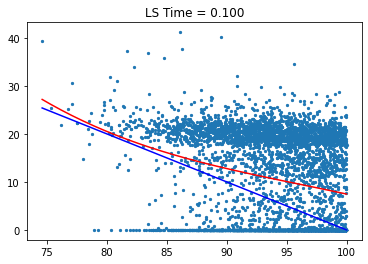

Longstaff-Schwartz Price = 7.79757


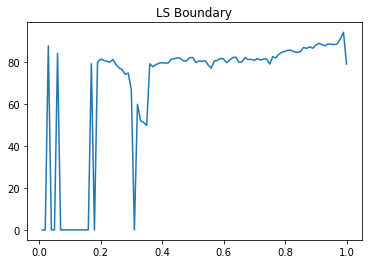

In [12]:
# main program starts here

# choose the problem parameters
# spot_price_val: float = 80.0 #100
# strike_val: float = 80.0 #100
# expiry_val: float = 1.0 #1.0
# rate_val: float = 0.03 #0.05
# vol_val: float = 0.3 #0.25
# # num_steps_val: int = 10 #10
# spot_price_frac_val: float = 0.25 #0.02
# is_call: bool = False # False
# num_laguerre: int = 3
# num_dt_val: int = 100 #100
# num_paths_val: int = 10000 # 10000
# seed = 0

spot_price_val: float = 100.0 #100
strike_val: float = 100.0 #100
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
# num_steps_val: int = 10 #10
spot_price_frac_val: float = 0.2 #0.02
is_call: bool = False # False
num_laguerre: int = 3
num_dt_val: int = 100 #100
num_paths_val: int = 10000 # 10000
seed = 0

np.random.seed(seed)
    
    
# original parameters from prof Rao's ls code
# is_call_val = False
# spot_price_val = 80.0
# strike_val = 80.0
# expiry_val = 1.0
# lognormal_val = True
# r_val = 0.03
# sigma_val = 0.3
# num_dt_val = 100
# num_paths_val = 10000
# num_laguerre_val = 3
# num_iters_val = 15
# epsilon_val = 1e-3
# spot_pct_noise_val = 0.25

    
    
# define the payoff function
payoff: Callable[[float],float]
if is_call:
    payoff = lambda x: max(0, x - strike_val)
else:
    payoff = lambda x: max(0, strike_val - x)
    
# define my feature functions (laguerre polynomials)
def laguerre_feature_func(
    s: NonTerminal[float],
    i: int,
    n: int,
    strike: float
) -> float:
    xp = s.state / strike
    coef = np.zeros((n,))
    coef[i] = 1
    return np.exp(-xp / 2) * lagval(xp, coef)

ffs: List[Callable[[NonTerminal[float]], float]] = [lambda _: 1.]
for i in range(num_laguerre):
    ff = lambda s,i=i: laguerre_feature_func(s,i,num_laguerre,strike_val)
    ffs += [ff]


# instantiate the OptimalExerciseLS class which computes price and exercise boundary
opt_ex_ls: OptimalExerciseLS = OptimalExerciseLS(
                                    spot_price = spot_price_val,
                                    payoff = payoff,
                                    expiry = expiry_val,
                                    rate = rate_val,
                                    vol = vol_val,
                                    num_steps = num_dt_val,
                                    spot_price_frac = spot_price_frac_val)
# # get the paths
# paths: np.ndarray = opt_ex_ls._get_all_paths(
#                                 spot_price_frac_val,
#                                 num_paths_val,
#                                 num_dt_val)
    
# # plot the paths
# # plot paths
# plt.figure(figsize=(15,10))
# for i in range(len(paths)):
#     x = list(range(len(paths[i])))
#     y = paths[i]
#     plt.plot(x,y)
# plt.show()



        
# get price
ls_price, ls_ex_boundary = opt_ex_ls.get_price(num_dt_val, num_paths_val, ffs)

# # get optimal (TODO: should it be a np.ndarray or a funtion?)
# ls_ex_boundary: np.ndarray = opt_ex_ls.get_exercise_boundary
    
# # TODO: print the exercise boundary

    
print("Longstaff-Schwartz Price = %.5f" % ls_price)

 - plot the vstar accross all states at a given time step for LS (since I have the optimal policy)
 - i should use the same delta t and same function approximations
     - not necessarily, hard to tell try to paint a good picture of the situation
 - make a mention that LS doesnt propagate error back and ADP does which is why ADP will do worst,
     - RL will have this benefit
 - make a mention in report to say that there is a computational (big) advantage to LS
     - so should I reuse the same dt in both?
 - LS and ADP doesn't tie approx at t=t0 and t=t1
     - RL does bind state and time together
- RL is path by path and LS as well 
- How would I go about implementing LSPI with this idea in mind?
    - ideally I would do lspi and dql (deep q learing, probably the best approach)
- implement the customize lspi for this problem (the code is probably on github, see rl > chapter 12 >optimal exercise rl
    - for lspi use simple polynomial instead of laguerre
    - maybe fix the A inversion for sherman morrisson (or it is possible the np.linalg.solve is wrong because it is sloppy with singular values)
    